# Action Grammars: A Grammar-Induction Based Method for Learning Temporally-Extended Actions
## Authors: Robert Lange and Aldo Faisal | January 2019

In [ ]:
!pip install -r requirements.txt --quiet

In [91]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
import os
import time
import numpy as np

import gym
import gym_hanoi

In [93]:
from agents import Agent_Q, SMDP_Agent_Q, Macro, SMDPQTable
from utils.q_learning import  q_learning
from utils.learning_params import *
from utils.general import *
from utils.plotting import *

In [94]:
# Create directory - Learning performance
results_dir = os.getcwd() + "/results/"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    print("Created New Results Directory")

# Create directory - Log directory
log_dir = os.getcwd() + "/logs/"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
    print("Created New Log Directory")
    
# Create directory - Figure directory
fig_dir = os.getcwd() + "/figures/"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print("Created New Fig Directory")

# Towers of Hanoi - Setup

In [95]:
num_episodes = 1000
max_steps = 1000

log_freq = 5  # greedily evaluate policy after amount of episodes
log_episodes = 5
learning_times = 5

verbose = True

alpha, gamma, lambd, epsilon = learning_parameters(l_type="Q-Learning")

In [96]:
learning_setup = {4: {"num_episodes": 100,
                      "max_steps": 500},
                  5: {"num_episodes": 1000,
                      "max_steps": 1000},
                  6: {"num_episodes": 5000,
                      "max_steps": 2000},
                  7: {"num_episodes": 10000,
                      "max_steps": 4000},
                  8: {"num_episodes": 20000,
                      "max_steps": 8000}}

### Simple TD($\lambda$) Learning

In [97]:
N = 5
num_episodes = learning_setup[5]["num_episodes"]
max_steps = learning_setup[5]["max_steps"]

In [98]:
def run_learning(num_times, num_disks, num_episodes, max_steps,
                 save_fname=None):
    its, steps, sd_steps, rew, sd_rew = [], [], [], [], []
    
    for i in range(num_times):
        print("Learning Run: {}".format(i+1))
        env = gym.make("Hanoi-v0")
        env.set_env_parameters(num_disks, env_noise=0, verbose=False)
        
        agent = Agent_Q(env)
        alpha, gamma, lambd, epsilon = learning_parameters(l_type="Q-Learning")
        hist, er_buffer = q_learning(env, agent, num_episodes, max_steps,
                                     gamma, alpha, lambd, epsilon,
                                     log_freq, log_episodes, False)

        # Process results and append
        its_t, steps_t, sd_steps_t, rew_t, sd_rew_t =  hist[:, 0], hist[:, 1], hist[:,2], hist[:, 3], hist[:, 4]
        its.append(its_t)
        steps.append(steps_t)
        sd_steps.append(sd_steps_t)
        rew.append(rew_t)
        sd_rew.append(sd_rew_t)
    
    its = np.array(its).mean(axis=0)
    steps = np.array(steps).mean(axis=0)
    sd_steps = np.array(sd_steps).mean(axis=0)
    rew = np.array(rew).mean(axis=0)
    sd_rew = np.array(sd_rew).mean(axis=0)
    
    if save_fname is not None:
        out = np.array([its, steps, sd_steps, rew, sd_rew])
        np.savetxt(save_fname, out)
    return its, steps, sd_steps, rew, sd_rew

In [99]:
its, steps, sd_steps, rew, sd_rew = run_learning(5, 5, num_episodes, max_steps)

Learning Run: 1
Learning Run: 2
Learning Run: 3
Learning Run: 4
Learning Run: 5


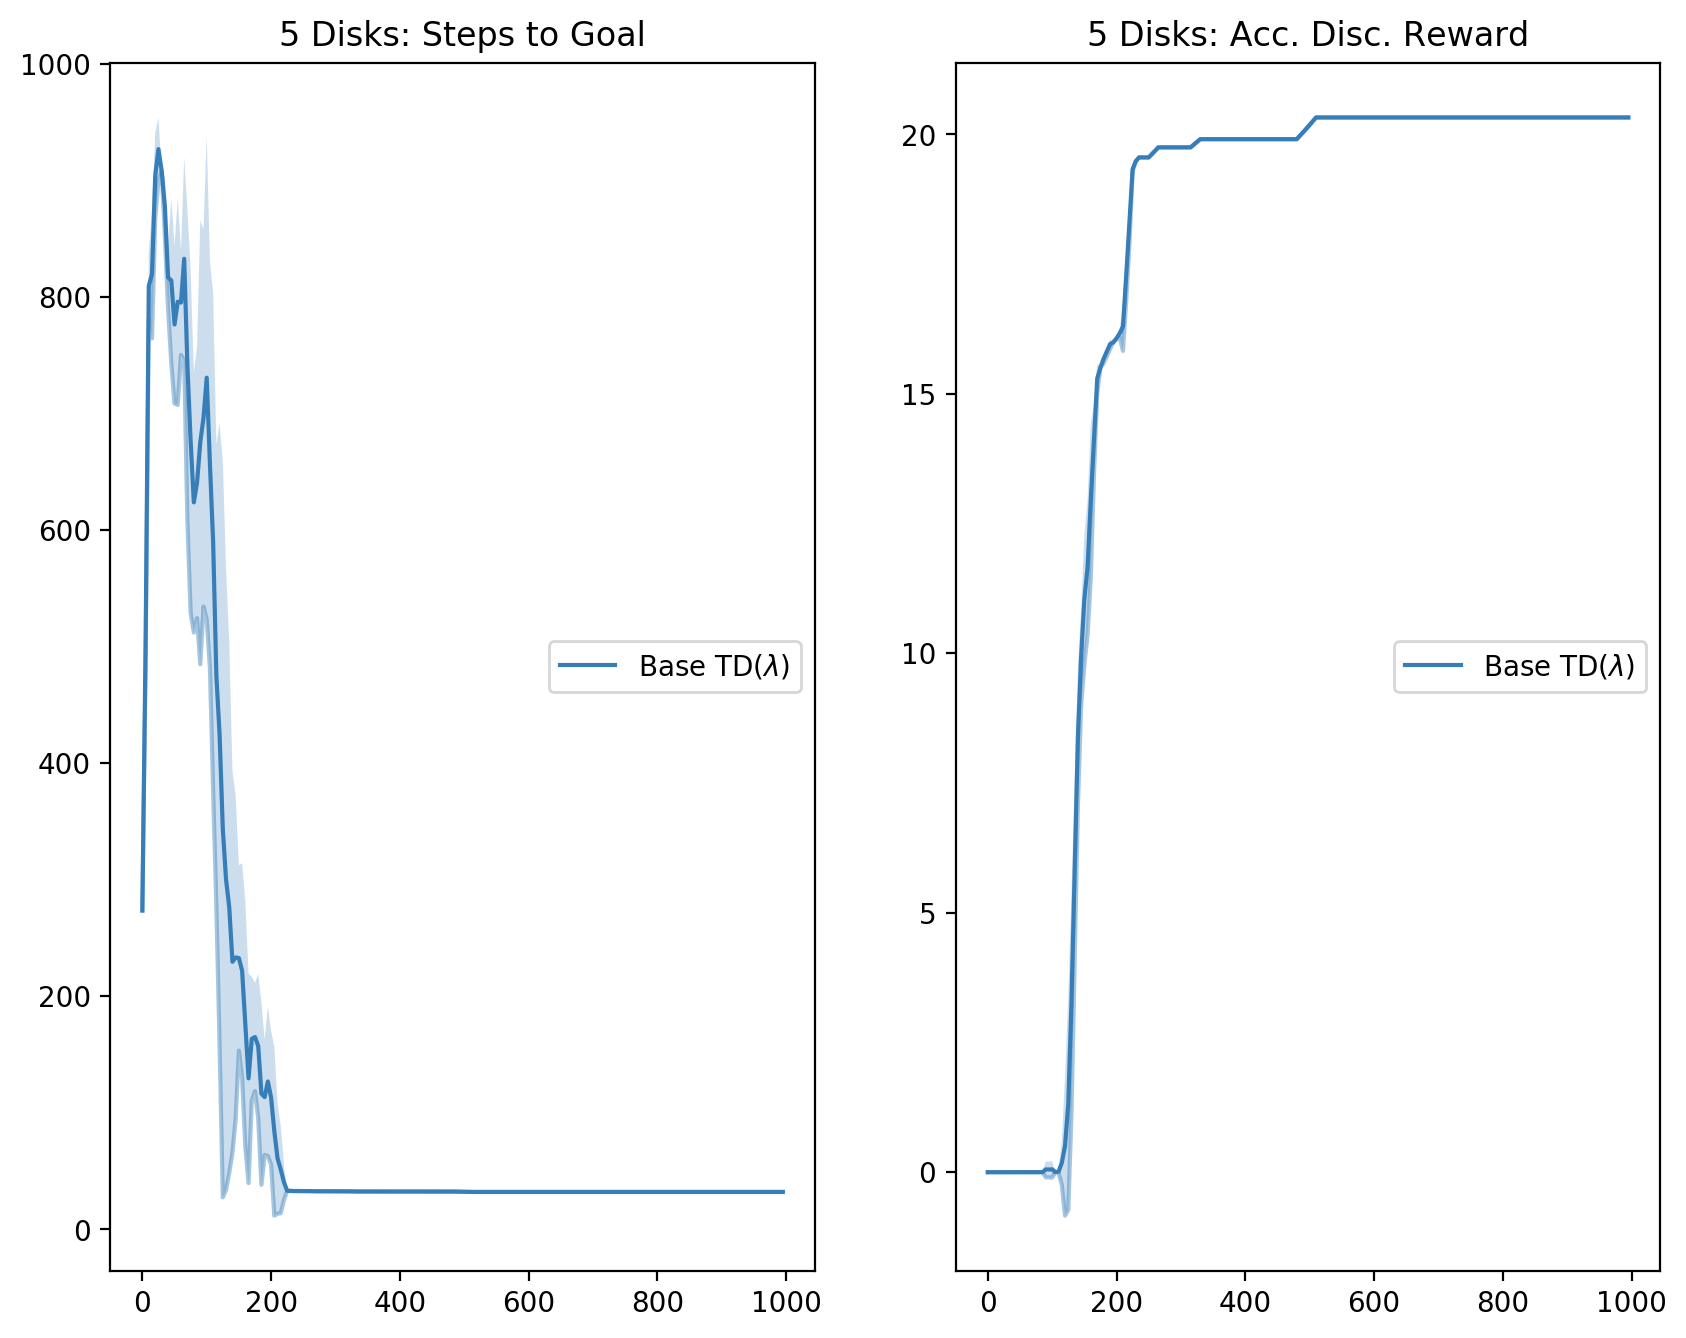

In [90]:
plot_all_learning([its], [steps], [sd_steps], [rew], [sd_rew], smooth_degree=3,
                  sub_titles=[r"5 Disks: Steps to Goal",
                              r"5 Disks: Acc. Disc. Reward"],
                  labels=[r"Base TD($\lambda$)"])

In [109]:
get_rollout_policy(env, agent, max_steps, grammar=False)

deque([(0, (0, 0, 0, 0, 0), 1, (2, 0, 0, 0, 0)),
       (1, (2, 0, 0, 0, 0), 0, (2, 1, 0, 0, 0)),
       (2, (2, 1, 0, 0, 0), 5, (1, 1, 0, 0, 0)),
       (3, (1, 1, 0, 0, 0), 1, (1, 1, 2, 0, 0)),
       (4, (1, 1, 2, 0, 0), 2, (0, 1, 2, 0, 0)),
       (5, (0, 1, 2, 0, 0), 3, (0, 2, 2, 0, 0)),
       (6, (0, 2, 2, 0, 0), 1, (2, 2, 2, 0, 0)),
       (7, (2, 2, 2, 0, 0), 0, (2, 2, 2, 1, 0)),
       (8, (2, 2, 2, 1, 0), 4, (0, 2, 2, 1, 0)),
       (9, (0, 2, 2, 1, 0), 5, (0, 1, 2, 1, 0)),
       (10, (0, 1, 2, 1, 0), 0, (1, 1, 2, 1, 0)),
       (11, (1, 1, 2, 1, 0), 4, (1, 1, 0, 1, 0)),
       (12, (1, 1, 0, 1, 0), 2, (0, 1, 0, 1, 0)),
       (13, (0, 1, 0, 1, 0), 3, (0, 2, 0, 1, 0)),
       (14, (0, 2, 0, 1, 0), 1, (2, 2, 0, 1, 0)),
       (15, (2, 2, 0, 1, 0), 0, (2, 2, 1, 1, 0)),
       (16, (2, 2, 1, 1, 0), 4, (0, 2, 1, 1, 0)),
       (17, (0, 2, 1, 1, 0), 5, (0, 1, 1, 1, 0)),
       (18, (0, 1, 1, 1, 0), 0, (1, 1, 1, 1, 0)),
       (19, (1, 1, 1, 1, 0), 1, (1, 1, 1, 1, 2)),
       (20

In [111]:
get_rollout_policy(env, agent, max_steps, grammar=True)

'bafbcdbaefaecdbaefabcdbcfecdbafbcdb'

### SMDP-Q-Learning

In [ ]:
seq_macros = {4: ["abd"],
              5: ["bafbcd", "baf", "ec", "bc"],
              6: ["abdaef", "abdced", "abdaef", "aedce",
                  "abdce", "abd", "ae", "ce"], 
              7: ["bafbcdbafecfbafbcdbcfecd", "bafbcdbafecf",
                  "bafecdbcfecbafbcdbcfec", "bafbcdbafec",
                  "bcfecbafbcec"]}

In [ ]:
N = 5
env = gym.make("Hanoi-v0")
env.set_env_parameters(num_disks=N, env_noise=0)

macros = []
for i in range(len(seq_macros[N])):
    macros.append(Macro(env, seq_macros[N][i]))

In [ ]:
Q = SMDPQTable(env.get_movability_map(), macros)

In [ ]:
agent = SMDP_Agent_Q(env, Q, macros)

In [ ]:
log_template = "Ep: {:>2} | Avg/Std Steps: {:.2f}/{:.2f} | Avg/Std Ret: {:.2f}/{:.2f} | Success R: {:.2f}"
log_counter = 0
hist = np.zeros((int(num_episodes/log_freq), 6))

# Init Replay Buffer
er_buffer = ReplayBuffer(num_episodes*max_steps)

for ep_id in range(num_episodes):

    cur_state = env.reset()

    stp = 0
    tot_td = 0
    rewards = []

    eligibility = np.zeros(agent.q_func.table.shape)

    old_greedy_choice = None
    old_action = None
    old_state = None

    for i in range(max_steps):
        action = agent.epsilon_greedy_action(cur_state)
        next_state, reward, done, _ = env.step(action)
        greedy_choice = agent.greedy_action(next_state)

        # Update value function
        eligibility, tde = q_learning_update(gamma, alpha, lambd, agent.q_func,
                                             eligibility, cur_state, action,
                                             next_state, reward, done, stp,
                                             old_greedy_choice, old_action, old_state)

        # Extend replay buffer
        er_buffer.push(ep_id, old_state, action, reward, next_state, done)

        # Update variables
        old_state = cur_state
        old_action = action
        old_greedy_choice = greedy_choice
        cur_state = next_state

        # Update counters
        stp += 1
        tot_td += tde
        rewards.append(reward)

        # Go to next episode if successfully ended
        if done:
            break

    if ep_id % log_freq == 0:
        avg_steps, sd_steps, avg_ret, sd_ret, success_rate = greedy_eval(env, agent, gamma,
                                                                         max_steps, log_episodes)
        hist[log_counter,:] = np.array([ep_id, avg_steps, sd_steps,
                                        avg_ret, sd_ret, success_rate])
        log_counter += 1

        if verbose:
            print(log_template.format(ep_id + 1, avg_steps, sd_steps,
                                      avg_ret, sd_steps, success_rate))

In [ ]:
er_buffer.buffer